In [38]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from torch.utils.data import DataLoader
import galsim
from dataset import Galaxy_Dataset, get_COSMOS_Galaxy, get_LSST_PSF
from models.Wiener import Wiener
from models.Richard_Lucy import Richard_Lucy
from models.Unrolled_ADMM import Unrolled_ADMM
from utils.utils import PSNR, estimate_shear

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define basic parameters

In [39]:
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/'
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 48
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

### Simulate PSF

In [40]:
rng = galsim.UniformDeviate(seed=19) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=34, mean=seeing, sigma=0.18)
# PSF parameters
atmos_fwhm = 0.7 # arcsec (mean 0.7 for LSST)
# while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
#     atmos_fwhm = rng_gaussian()
# atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_e = 0.6 * atmos_max_shear
# atmos_beta = 2. * np.pi * rng()     # radians
atmos_beta = 2. * np.pi * 0.5     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)
pixel_scale = pixel_scale

psf = get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                    atmos_fwhm, atmos_e, atmos_beta, 0, 0,
                    fov_pixels, pixel_scale=pixel_scale) 
psf_delta = np.zeros([fov_pixels, fov_pixels])
psf_delta[int(fov_pixels/2)-1,int(fov_pixels/2)-1] = 1

### Simulate galaxy

In [41]:
idx = 245 # index pf galaxy in the catalog

# Galaxy parameters 
gal_e = rng() * gal_max_shear       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
gal_shear = galsim.Shear(e=gal_e, beta=gal_beta*galsim.radians)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians
sky_level = 1.e3                     # ADU / arcsec^2
dx, dy = rng() - 0.5, rng() - 0.5

snr_list = [100, 50, 20, 10]
# gal_flux_list = [6.25e4, 2.5e4, 1e4, 0.75e4, 0.4e4]
gal_flux_list = []
gt_list, gt_shear_list = [], []
for snr in snr_list:  
    gal_flux = (snr**2) * (1 + np.sqrt(1 + 8*sky_level*(fov_pixels**2)*(pixel_scale**2)/(snr**2)))/2
    gal_flux_list.append(gal_flux)
    gt, gal_orig = get_COSMOS_Galaxy(catalog=real_galaxy_catalog, idx=idx, 
                                     gal_flux=gal_flux, sky_level=sky_level, 
                                     gal_e=gal_e, gal_beta=gal_beta, 
                                     theta=theta, gal_mu=gal_mu, dx=dx, dy=dy, 
                                     fov_pixels=fov_pixels, pixel_scale=pixel_scale)
    gt_list.append(gt)
    gt_shear_list.append(estimate_shear(gt.numpy(),psf_delta)[2])
    # snr = gal_flux/np.sqrt(gal_flux + sky_level*(fov_pixels**2)*(pixel_scale**2))
    # snr_list.append(snr)
    print('gal_flux={:.1f} \tSNR={:.1f}'.format(gal_flux, snr))


gal_flux=48222.7 	SNR=100.0
gal_flux=22752.6 	SNR=50.0
gal_flux=8788.8 	SNR=20.0
gal_flux=4343.5 	SNR=10.0


### Simulate Observation

In [42]:
obs_list, obs_ori_list = [], []
for gt in gt_list:
    # Convolution via FFT
    conv = ifftshift(ifft2(fft2(psf) * fft2(gt))).real
    conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

    # Add CCD noise (Poisson + Gaussian)
    obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=2*torch.ones_like(conv))
    obs_ori = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero
    obs = (obs_ori - obs_ori.min())/(obs_ori.max() - obs_ori.min())

    obs_list.append((obs, estimate_shear(obs.numpy(),psf_delta)[2], PSNR(obs,gt)))
    obs_ori_list.append(obs_ori)

### Wiener Deconvolution

In [43]:
rec_wiener = []
for (obs,_,_), snr in zip(obs_list, snr_list):
    rec = fftshift(ifft2(fft2(obs) / fft2(psf) / (1+1/(fft2(psf).abs()**2 * snr)) )).real
    rec_wiener.append((rec, estimate_shear(rec.numpy(),psf_delta)[2], PSNR(rec,gt)))

### Richardson-Lucy Deconvolution

In [44]:
iter_list = [20,100]

rec_RL = [[], []]
for idx, n_iters in enumerate(iter_list):
    model = Richard_Lucy(n_iters=n_iters)
    model.to(device)
    model.eval()
    for (obs,_,_), gal_flux in zip(obs_list, gal_flux_list):
        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
        rec = output.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
        rec_shear = estimate_shear(rec,psf_delta)[2]
        rec_psnr = PSNR(rec,gt)
        # rec -= rec.min()
        rec = np.where(rec>0,rec,0)
        rec_img = rec/rec.sum() * (gal_flux + sky_level*(pixel_scale**2)*(fov_pixels**2))
        # rec_img = rec/rec.sum() * gal_flux #+ sky_level*(pixel_scale**2)
        rec_RL[idx].append((rec_img, rec_shear, rec_psnr))

### Unrolled ADMM

In [45]:
iter_list = [1,4]
rec_admm = [[], []]
model_files = ['saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth', 
               'saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth']
for idx, (n_iters, model_file) in enumerate(zip(iter_list, model_files)):
    model = Unrolled_ADMM(n_iters=n_iters, llh='Poisson', PnP=True)
    model.to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for (obs,_,_), gal_flux in zip(obs_list, gal_flux_list):
        alpha = obs.ravel().mean()/0.33
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        rec = (output.cpu() * alpha.cpu()).squeeze(dim=0).squeeze(dim=0).detach().numpy()
        rec_shear = estimate_shear(rec,psf_delta)[2]
        rec_psnr = PSNR(rec,gt)
        # rec -= rec.min()
        rec = np.where(rec>0,rec,0)
        rec_img = rec/rec.sum() * (gal_flux + sky_level*(pixel_scale**2)*(fov_pixels**2))
        # rec_img = rec/rec.sum() * gal_flux #+ sky_level*(pixel_scale**2)
        rec_admm[idx].append((rec_img, rec_shear, rec_psnr))
    

Successfully loaded in saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth.
Successfully loaded in saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth.


### Grid Plot

[tensor(511.2856), 1088.0852, 1168.9502, 1287.17, 849.55536]
[tensor(144222.3438), 140382.66, 140382.66, 140382.69, 140382.66]
1287.17
[tensor(258.4920), 600.5167, 682.92224, 782.182, 856.0679]
[tensor(116053.0625), 114912.61, 114912.625, 114912.62, 114912.61]
856.0679
[tensor(120.3813), 243.66953, 316.31387, 434.53708, 394.50833]
[tensor(101660.7656), 100948.81, 100948.82, 100948.83, 100948.83]
434.53708
[tensor(86.7517), 168.19273, 194.86063, 297.43933, 281.15656]
[tensor(96435.2969), 96503.54, 96503.55, 96503.54, 96503.54]
297.43933


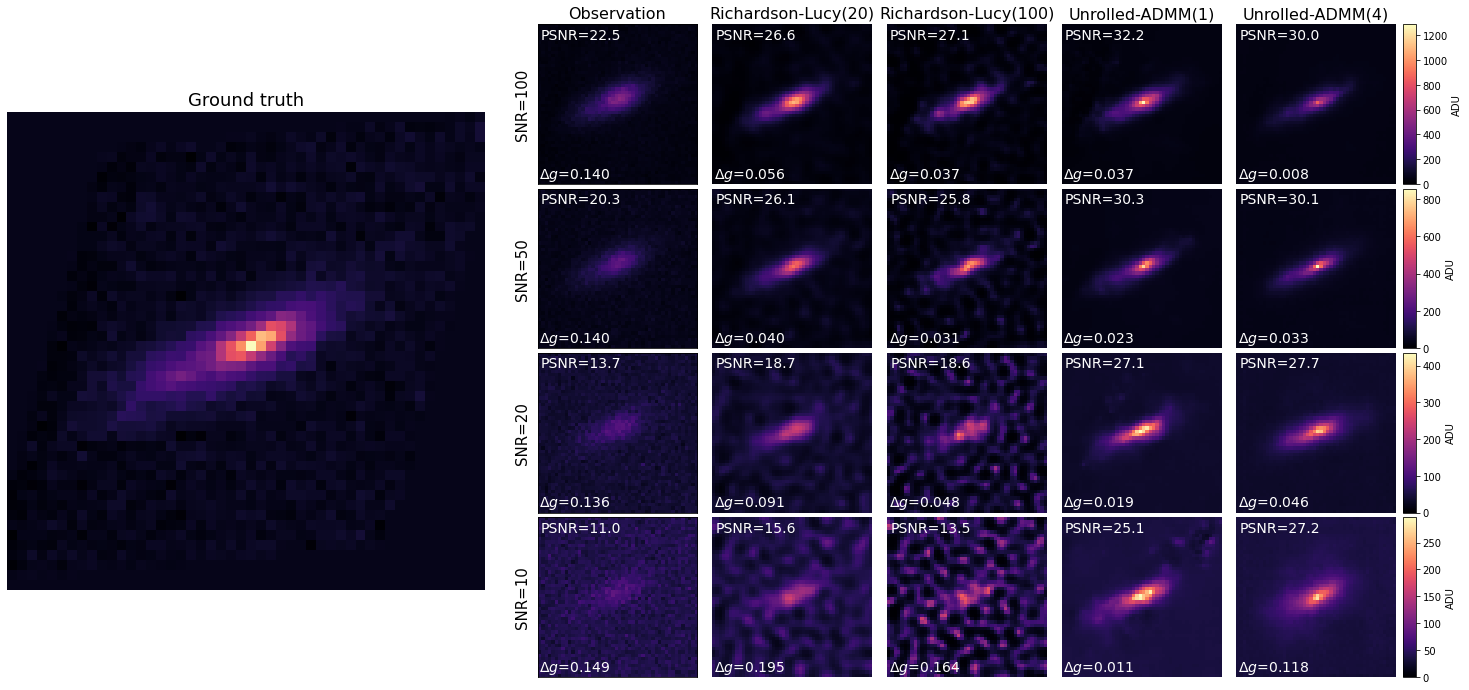

In [46]:
fig = plt.figure(figsize=(25,12), facecolor='white')
ax = plt.gca()
gs = gridspec.GridSpec(8, 32)
cmap = 'magma'

plt.subplot(gs[1:7,0:11])
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.imshow(gt, cmap=cmap)
plt.axis('off')
plt.title('Ground truth', fontsize=18)
        
for idx, (snr, obs, obs_ori, gt_shear, rec_RL_20, rec_RL_100, rec_1, rec_4) in enumerate(zip(snr_list, obs_list, obs_ori_list, gt_shear_list, rec_RL[0], rec_RL[1], rec_admm[0], rec_admm[1])):
    vmax = np.max([obs_ori.max(), rec_RL_20[0].max(), rec_RL_100[0].max(), rec_1[0].max(), rec_4[0].max()])
    print([obs_ori.max(), rec_RL_20[0].max(), rec_RL_100[0].max(), rec_1[0].max(), rec_4[0].max()])
    print([obs_ori.sum(), rec_RL_20[0].sum(), rec_RL_100[0].sum(), rec_1[0].sum(), rec_4[0].sum()])
    print(vmax)
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=0)
    
    ax2 = plt.subplot(gs[2*idx:2*idx+2,12:16])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(obs_ori, cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(obs[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(obs[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.ylabel("SNR={:.0f}".format(snr), fontsize=15)
    # plt.axis('off')
    ax2.set_xticks([])
    ax2.set_yticks([])
    if idx == 0:
        plt.title('Observation', fontsize=16)
    # if idx < 3:
    #     ax2.set_xticks([])

    # ax3 = plt.subplot(gs[2*idx:2*idx+2,12:16])
    # plt.subplots_adjust(wspace=0.06, hspace=0.06)
    # plt.imshow(rec_fd, cmap=cmap)
    # plt.title("PSNR={:.1f}".format(PSNR(rec_fd,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    # plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(rec_fd.numpy(),psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    # # plt.axis('off')
    # ax3.set_yticks([])
    # if idx == 0:
    #     plt.title('Wiener', fontsize=16)
    # if idx < 3:
    #     ax3.set_xticks([])

    ax4 = plt.subplot(gs[2*idx:2*idx+2,16:20])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL_20[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_RL_20[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_RL_20[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    # ax4.set_yticks([])
    if idx == 0:
        plt.title('Richardson-Lucy(20)', fontsize=16)
    # if idx < 3:
    #     ax4.set_xticks([])

    ax5 = plt.subplot(gs[2*idx:2*idx+2,20:24])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL_100[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_RL_100[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_RL_100[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    # ax5.set_yticks([])
    if idx == 0:
        plt.title('Richardson-Lucy(100)', fontsize=16)
    # if idx < 3:
    #     ax5.set_xticks([])

    ax6 = plt.subplot(gs[2*idx:2*idx+2,24:28])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_1[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_1[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_1[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    # ax6.set_yticks([])
    if idx == 0:
        plt.title('Unrolled-ADMM(1)', fontsize=16)
    # if idx < 3:
    #     ax6.set_xticks([])

    ax7 = plt.subplot(gs[2*idx:2*idx+2,28:32])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_4[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_4[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_4[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    # ax7.set_yticks([])
    if idx == 0:
        plt.title('Unrolled-ADMM(4)', fontsize=16)
    # if idx < 3:
    #     ax7.set_xticks([])
    cax = fig.add_axes([ax7.get_position().x1+4e-3,ax7.get_position().y0,7e-3,ax7.get_position().height])
    plt.colorbar(cax=cax, label='ADU')
    
plt.savefig('figures/grid.eps', bbox_inches='tight')